# 1. Titanic Survival Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

### 1.1 Data
컬럼 정보
- Survived : 생존 유무 (정답)
- Pclass : 탑승한 여객 클래스
- Sex : 성별
- Age : 나이
- Fare : 운임료
- Embarked: 승선항구 위치
    - C = Cherbourg; Q = Queenstown; S = Southampton

In [2]:
titanic = pd.read_csv("../02. Data/simple_titanic.csv")

titanic.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked'], dtype='object')

In [3]:
label = titanic["Survived"]
data = titanic.drop(["Survived"], axis=1)

### 1.2 EDA

In [4]:
data.describe()

,Pclass,Age,Fare
count,1306.000000,1043.000000,1306.000000
mean,2.296325,29.813202,33.223956
std,0.837037,14.366254,51.765986
min,1.000000,0.170000,0.000000
25%,2.000000,21.000000,7.895800
50%,3.000000,28.000000,14.454200
75%,3.000000,39.000000,31.275000
max,3.000000,80.000000,512.329200


In [5]:
# Sex, Embarked 컬럼 비율 확인
print(data["Sex"].value_counts(), '\n')
print(data["Embarked"].value_counts())

male      842
female    464
Name: Sex, dtype: int64 

S    913
C    270
Q    123
Name: Embarked, dtype: int64


In [6]:
# 결측값 확인
data.isna().sum()

Pclass        0
Sex           0
Age         263
Fare          0
Embarked      0
dtype: int64

In [7]:
# 정답 비율 확인
label.value_counts()

0    814
1    492
Name: Survived, dtype: int64

### 1.3 Preprocess

In [8]:
data.loc[:, "Sex"] = data["Sex"].map({"male": 0, "female": 1})
data.loc[:, "Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})

In [9]:
# Sex, Embarked 컬럼 비율 확인
print(data["Sex"].value_counts(), '\n')
print(data["Embarked"].value_counts())

0    842
1    464
Name: Sex, dtype: int64 

0    913
1    270
2    123
Name: Embarked, dtype: int64


### 1.4 Split

In [10]:
from sklearn.model_selection import train_test_split

train_data, validation_data, train_label, validation_label = train_test_split(data, label, train_size=0.6, random_state=2021)

valid_data, test_data, valid_label, test_label = train_test_split(validation_data, validation_label, train_size=0.5, random_state=2021)

In [11]:
print(f"train_data size: {len(train_label)}, {len(train_label)/len(data):.2f}")
print(f"valid_data size: {len(valid_label)}, {len(valid_label)/len(data):.2f}")
print(f"test_data size: {len(test_label)}, {len(test_label)/len(data):.2f}")

train_data size: 783, 0.60
valid_data size: 261, 0.20
test_data size: 262, 0.20


In [12]:
# 뒤에서 index 리셋 해야되므로 미리 진행
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_label = train_label.reset_index(drop=True)
valid_label = valid_label.reset_index(drop=True)
test_label = test_label.reset_index(drop=True)

# 2. How to fill in empty data
빈 값이 많은 Age를 어떻게 채울까  
1. 사용하지 않는다.
2. 전체 데이터의 평균으로 채운다.
3. 비슷한 데이터를 찾아서 비슷한 데이터의 평균으로 채운다.

In [13]:
# 결측 컬럼 확인
na_cnt = data.isna().sum()
na_cnt.loc[na_cnt > 0].index

Index(['Age'], dtype='object')

### 2.1 How Not to Use

In [14]:
drop_data = data.dropna()

print(f"전체 데이터 개수: {len(data)}")
print(f"값이 비어있는 데이터를 버린 후 데이터 개수: {len(drop_data)}")
print(f"버려진 데이터 개수: {len(data) - len(drop_data)}")

전체 데이터 개수: 1306
값이 비어있는 데이터를 버린 후 데이터 개수: 1043
버려진 데이터 개수: 263


### 2.2 Fill with the mean of the entire data

In [15]:
mean_train_data = train_data.copy()
mean_valid_data = valid_data.copy()
mean_test_data = test_data.copy()

In [16]:
# 학습 데이터의 Age 평균
age_mean = mean_train_data["Age"].mean()
age_mean

30.13604100946372

In [17]:
# 전체 데이터의 평균으로 결측값 대체
mean_train_data.loc[:, "Age"] = mean_train_data["Age"].fillna(age_mean)
mean_valid_data.loc[:, "Age"] = mean_valid_data["Age"].fillna(age_mean)
mean_test_data.loc[:, "Age"] = mean_test_data["Age"].fillna(age_mean)

mean_train_data.isna().sum()

Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
dtype: int64

### 2.3 Populate by means of similar data
이 방법은 빈 값이 있는 변수를 제거하고 나머지 변수들을 군집화하고 군집의 평균으로 빈 값을 채우는 방법  
아이디어는 비슷한 데이터들은 변수 몇 개를 제거해도 같이 묶일 것이다에서 시작

In [18]:
cluster_train_data = train_data.copy()
cluster_valid_data = valid_data.copy()
cluster_test_data = test_data.copy()

In [19]:
# 클러스터링 하기 전 데이터 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(cluster_train_data.drop(["Age"], axis=1))

StandardScaler()

In [20]:
train_fill_data = scaler.transform(cluster_train_data.drop(["Age"], axis=1))
valid_fill_data = scaler.transform(cluster_valid_data.drop(["Age"], axis=1))
test_fill_data = scaler.transform(cluster_test_data.drop(["Age"], axis=1))

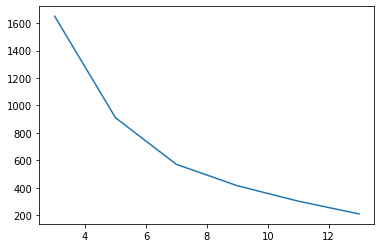

In [21]:
# 최적 K를 찾기 위해 K값에 따른 SSE 계산 후 시각화
from sklearn.cluster import KMeans

n_cluster = []
sse = []
for n in range(3, 15, 2):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(train_fill_data)
    n_cluster += [n]
    sse += [kmeans.inertia_]
    
plt.plot(n_cluster, sse)

In [22]:
## SSE 그래프에서 꺾이는 지점인 7로 K 지정
n_clusters = 7

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(train_fill_data)

KMeans(n_clusters=7)

In [23]:
clustered_train = kmeans.predict(train_fill_data)
clustered_valid = kmeans.predict(valid_fill_data)
clustered_test = kmeans.predict(test_fill_data)

clustered_test

array([2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 0, 2, 1, 2, 2, 4, 2, 5,
       0, 0, 6, 2, 5, 2, 1, 2, 2, 5, 2, 2, 5, 2, 4, 3, 0, 2, 2, 0, 2, 0,
       2, 1, 3, 4, 2, 2, 4, 2, 0, 1, 2, 4, 5, 2, 2, 2, 3, 4, 0, 0, 2, 1,
       5, 5, 0, 2, 2, 5, 4, 3, 6, 2, 5, 4, 2, 4, 4, 5, 1, 2, 2, 0, 2, 3,
       2, 2, 5, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 4, 0, 4, 2,
       2, 5, 5, 4, 3, 5, 6, 3, 3, 4, 4, 0, 5, 3, 2, 4, 4, 2, 0, 4, 4, 4,
       2, 2, 1, 0, 0, 4, 2, 2, 6, 2, 2, 4, 2, 2, 1, 0, 3, 4, 2, 2, 2, 2,
       2, 5, 2, 5, 5, 6, 0, 2, 2, 6, 1, 2, 2, 0, 0, 4, 5, 5, 2, 2, 4, 4,
       2, 3, 2, 6, 2, 4, 4, 2, 5, 5, 2, 1, 2, 1, 2, 1, 2, 4, 4, 1, 1, 2,
       2, 4, 2, 4, 4, 3, 3, 5, 2, 4, 3, 2, 3, 2, 3, 4, 0, 0, 1, 2, 4, 0,
       5, 0, 5, 4, 5, 2, 3, 4, 2, 4, 1, 2, 6, 5, 0, 0, 2, 4, 2, 0, 2, 4,
       0, 2, 5, 2, 2, 0, 2, 5, 2, 2, 1, 1, 2, 2, 2, 5, 4, 2, 0, 5])

In [24]:
# 각 군집에서 빈 값 채울 값 확인
cluster_fill_value = {}
for i in range(n_clusters):
    class_mean = cluster_train_data.loc[clustered_train == i, "Age"].dropna().mean()
    cluster_fill_value[i] = class_mean
    
cluster_fill_value

{0: 40.46551724137931,
 1: 21.666666666666668,
 2: 27.871728395061727,
 3: 37.17910447761194,
 4: 24.838064516129034,
 5: 29.25,
 6: 41.404761904761905}

In [25]:
# 빈 값 가지고 잇는 데이터 Index 확인
train_na_idx = cluster_train_data.loc[cluster_train_data["Age"].isna()].index

train_na_idx

Int64Index([  2,   3,   9,  17,  26,  31,  41,  49,  53,  68,
            ...
            727, 732, 733, 742, 747, 754, 760, 764, 766, 777],
           dtype='int64', length=149)

In [26]:
# 인덱스가 속하는 군집 확인
clustered_train[train_na_idx]

array([2, 0, 2, 0, 5, 1, 2, 4, 2, 5, 0, 0, 4, 0, 2, 1, 5, 5, 2, 2, 1, 1,
       2, 6, 5, 2, 2, 2, 5, 5, 5, 2, 2, 5, 0, 5, 2, 3, 4, 0, 3, 0, 1, 0,
       0, 0, 2, 2, 5, 2, 1, 4, 2, 2, 2, 0, 2, 1, 3, 4, 2, 4, 1, 2, 2, 5,
       2, 4, 3, 5, 5, 5, 2, 3, 1, 2, 2, 1, 3, 5, 0, 3, 1, 1, 6, 4, 5, 5,
       1, 2, 1, 5, 4, 3, 5, 1, 5, 0, 2, 2, 5, 5, 2, 2, 1, 5, 1, 1, 3, 5,
       1, 0, 1, 5, 5, 1, 5, 2, 2, 0, 2, 5, 5, 5, 2, 2, 5, 2, 0, 2, 2, 4,
       5, 4, 2, 5, 2, 4, 5, 0, 2, 5, 2, 3, 4, 0, 0, 5, 5])

In [27]:
# 각 인덱스에 채울 값 가져오기
train_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_train[train_na_idx]))

train_fill_value[:10]

[27.871728395061727,
 40.46551724137931,
 27.871728395061727,
 40.46551724137931,
 29.25,
 21.666666666666668,
 27.871728395061727,
 24.838064516129034,
 27.871728395061727,
 29.25]

In [28]:
# 결측값 대체
cluster_train_data.loc[train_na_idx, "Age"] = train_fill_value

# 결측값 확인
cluster_train_data.loc[train_na_idx]

,Pclass,Sex,Age,Fare,Embarked
2,3,0,27.871728,69.5500,0
3,1,0,40.465517,30.5000,0
9,3,0,27.871728,7.8792,0
17,1,0,40.465517,25.9250,0
26,3,0,29.250000,15.5000,2
...,...,...,...,...,...
754,3,1,24.838065,14.5000,0
760,1,0,40.465517,0.0000,0
764,1,0,40.465517,27.7208,1
766,3,0,29.250000,6.8583,2


In [29]:
# 학습 데이터와 마찬가지로 검증/테스트 데이터에도 동일하게 진행
# 정규화와 동일하게 Train 데이터에서 구한 값으로 결측치 대체
valid_na_idx = cluster_valid_data.loc[cluster_valid_data["Age"].isna()].index
valid_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_valid[valid_na_idx]))

test_na_idx = cluster_test_data.loc[cluster_test_data["Age"].isna()].index
test_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_test[test_na_idx]))

cluster_valid_data.loc[valid_na_idx, "Age"] = valid_fill_value
cluster_test_data.loc[test_na_idx, "Age"] = test_fill_value

# 3. Model(RF)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### 3.1 Hyper-Parameter Tuning
각 데이터에 대해서 최고의 성능을 보이는 `n_estimators`를 탐색

#### 3.1.1 Data filled with the average of the entire data

In [31]:
n_estimators = [n for n in range(50, 1050, 50)]

mean_accuracy = []
for n_estimator in n_estimators:
    mean_random_forest = RandomForestClassifier(n_estimators=n_estimator)
    mean_random_forest.fit(mean_train_data, train_label)
    mean_valid_pred = mean_random_forest.predict(mean_valid_data)
    mean_accuracy += [accuracy_score(valid_label, mean_valid_pred)]

In [32]:
list(zip(n_estimators, mean_accuracy))

[(50, 0.8582375478927203),
 (100, 0.8582375478927203),
 (150, 0.8544061302681992),
 (200, 0.8582375478927203),
 (250, 0.8620689655172413),
 (300, 0.8582375478927203),
 (350, 0.8544061302681992),
 (400, 0.8582375478927203),
 (450, 0.8544061302681992),
 (500, 0.8582375478927203),
 (550, 0.8544061302681992),
 (600, 0.8582375478927203),
 (650, 0.8620689655172413),
 (700, 0.8544061302681992),
 (750, 0.8582375478927203),
 (800, 0.8582375478927203),
 (850, 0.8544061302681992),
 (900, 0.8582375478927203),
 (950, 0.8582375478927203),
 (1000, 0.8582375478927203)]

In [33]:
mean_best_n_estimator = n_estimators[np.argmax(mean_accuracy)]
print(f"Best n_estimator for mean data is {mean_best_n_estimator}, it's valid accuracy is {max(mean_accuracy):.4f}")

Best n_estimator for mean data is 250, it's valid accuracy is 0.8621


#### 3.1.2 Data filled with the average of similar data

In [34]:
cluster_accuracy = []
for n_estimator in n_estimators:
    cluster_random_forest = RandomForestClassifier(n_estimators=n_estimator)
    cluster_random_forest.fit(cluster_train_data, train_label)
    cluster_valid_pred = cluster_random_forest.predict(cluster_valid_data)
    cluster_accuracy += [accuracy_score(valid_label, cluster_valid_pred)]

In [35]:
list(zip(n_estimators, cluster_accuracy))

[(50, 0.8544061302681992),
 (100, 0.8505747126436781),
 (150, 0.8544061302681992),
 (200, 0.8544061302681992),
 (250, 0.8582375478927203),
 (300, 0.8582375478927203),
 (350, 0.8544061302681992),
 (400, 0.8544061302681992),
 (450, 0.8582375478927203),
 (500, 0.8582375478927203),
 (550, 0.8582375478927203),
 (600, 0.8582375478927203),
 (650, 0.8544061302681992),
 (700, 0.8544061302681992),
 (750, 0.8582375478927203),
 (800, 0.8620689655172413),
 (850, 0.8582375478927203),
 (900, 0.8620689655172413),
 (950, 0.8544061302681992),
 (1000, 0.8544061302681992)]

In [36]:
cluster_best_n_estimator = n_estimators[np.argmax(cluster_accuracy)]
print(f"Best n_estimator for cluster data is {cluster_best_n_estimator}, it's valid accuracy is {max(cluster_accuracy):.4f}")

Best n_estimator for cluster data is 800, it's valid accuracy is 0.8621


#### 3.1.3 Best Parameter

In [37]:
mean_random_forest = RandomForestClassifier(n_estimators=mean_best_n_estimator)
cluster_random_forest = RandomForestClassifier(n_estimators=cluster_best_n_estimator)

### 3.2 Learning

In [38]:
mean_random_forest.fit(mean_train_data, train_label)
cluster_random_forest.fit(cluster_train_data, train_label)

RandomForestClassifier(n_estimators=800)

### 3.3 Predict

In [39]:
mean_test_pred = mean_random_forest.predict(mean_test_data)
cluster_test_pred = cluster_random_forest.predict(cluster_test_data)

### 3.4 Evalution

In [40]:
mean_test_accuracy = accuracy_score(test_label, mean_test_pred)
cluster_test_accuracy = accuracy_score(test_label, cluster_test_pred)

print(f"Test Accuracy for mean data is {mean_test_accuracy:.4f}")
print(f"Test Accuracy for cluster data is {cluster_test_accuracy:.4f}")

Test Accuracy for mean data is 0.8588
Test Accuracy for cluster data is 0.8626
